# Imports necesarios para el modelo

In [2]:
# Imports para lectura, manipulación y visualización de datos
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import os

# Imports para el modelo 
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import math

# Dataset del Consumo de Energía

Dado que el [dataset](https://www.cenace.gob.mx/Paginas/SIM/Reportes/PronosticosDemanda.aspx) que se encuentra en la página de la CENACE es un archivo winrar, y dentro de este archivo están los pronósticos de demanda DIARIOS; sin una columna de la fecha que se recopilaron los datos, tuvimos que crear una función que concatenara todos los archivos, además, crear una columna que indicara el día en el que fue creado el dataset para que cada registro correspondiera al día en cuestión.

In [2]:
def combine_csv_files(carpet_path, output_filename):
    # Obtener la lista de archivos CSV en el directorio especificado
    csv_files = [os.path.join(carpet_path, file) for file in os.listdir(carpet_path) if file.endswith(".csv")]

    # Columnas a excluir durante la concatenación
    exclude_columns = ['SISTEMA', 'AREA', 'ZONA', 'HORA', 'PRONOSTICO_MWH']

    month_mapping = {
        'ene': 'Jan',
        'feb': 'Feb',
        'mar': 'Mar',
        'abr': 'Apr',
        'may': 'May',
        'jun': 'Jun',
        'jul': 'Jul',
        'ago': 'Aug',
        'sep': 'Sep',
        'oct': 'Oct',
        'nov': 'Nov',
        'dic': 'Dec'
    }
    
    # Cargar los archivos CSV en DataFrames
    dfs = []
    for file in csv_files:
        with open(file, 'r') as f:
            # Leer la fila 10 y extraer la fecha
            lines = f.readlines()
            match = re.search(r'\d{2}/\w+/\d{4}', lines[10])
            date = match.group(0) if match else None

        # Cargar el archivo CSV en un DataFrame
        df = pd.read_csv(file, skiprows=7)

        # Agregar la columna 'Date' con la fecha extraída
        df['Date'] = date
        for month_es, month_en in month_mapping.items():
            df['Date'] = df['Date'].str.replace(month_es, month_en)
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%b/%Y').dt.strftime('%Y-%m-%d')

        # Excluir las columnas no deseadas si existen en el DataFrame
        columns_to_drop = [col for col in exclude_columns if col in df.columns]
        if columns_to_drop:
            df = df.drop(columns=columns_to_drop)
        dfs.append(df)

    # Concatenar los DataFrames en uno solo
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])

    # Exportar el DataFrame a un archivo CSV con el nombre especificado
    combined_df.to_csv(output_filename, index=False)


In [412]:
# Carpeta CENACE debe contener los archivos CSV extraídos del archivo rar de CENACE
carpet_path = r"C:\Users\Panda\Documents\GitHub\energyPrediction\cenace"
nombre = "combined_df.csv"
combine_csv_files(carpet_path, nombre)

# Este código sólo se corrió una vez ya que la concatenación de todos los archivos CSV toma mucho tiempo y no es necesario volver a hacerlo

In [5]:
# Leer el archivo CSV combinado
combined_df = pd.read_csv('combined_df.csv')

In [7]:
# Observamos la información del DataFrame
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4171364 entries, 0 to 4171363
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Sistema            object 
 1    Area              object 
 2    Zona de Carga     object 
 3    Hora              float64
 4    Pronostico (MWh)  float64
 5   Date               object 
dtypes: float64(2), object(4)
memory usage: 191.0+ MB


In [41]:
# Cambiamos el tipo de dato de la columna 'Date' a datetime
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Tomamos el promedio de energia diaria consumida por zona de carga
energy = combined_df.groupby(['Date', ' Zona de Carga'], as_index=False)[' Pronostico (MWh)'].sum()
energy = energy.reset_index(drop=True)
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168706 entries, 0 to 168705
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               168706 non-null  datetime64[ns]
 1    Zona de Carga     168706 non-null  object        
 2    Pronostico (MWh)  168706 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.9+ MB


In [9]:
# Vemos las fecha de inicio y fin de los datos
print("Día de inicio de los datos",min(energy.Date))
print("Día final de los datos",max(energy.Date))

Día de inicio de los datos 2019-01-09 00:00:00
Día final de los datos 2023-06-02 00:00:00


# Datos Climatológicos

Este [dataset](https://power.larc.nasa.gov/data-access-viewer/) se obtuvo gracias a la información proporcionada por la NASA.

In [10]:
# Leemos los datos
clima_df = pd.read_csv('clima.csv', skiprows=18)

# Convertir las columnas 'YEAR', 'MO' y 'DY' en una columna de fecha con el formato '%Y-%m-%d'
clima_df['Date'] = pd.to_datetime(clima_df[['YEAR', 'MO', 'DY']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')

# Eliminar las primeras 3 columnas ya que no son necesarias
clima_df = clima_df.drop(columns=['YEAR', 'MO', 'DY'])
clima_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ALLSKY_SFC_UV_INDEX  1605 non-null   float64       
 1   WS2M                 1605 non-null   float64       
 2   T2M                  1605 non-null   float64       
 3   T2MDEW               1605 non-null   float64       
 4   T2MWET               1605 non-null   float64       
 5   T2M_MAX              1605 non-null   float64       
 6   T2M_MIN              1605 non-null   float64       
 7   QV2M                 1605 non-null   float64       
 8   RH2M                 1605 non-null   float64       
 9   PS                   1605 non-null   float64       
 10  Date                 1605 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(10)
memory usage: 138.1 KB


**Significado de los parámetros con sus respectivas unidades**

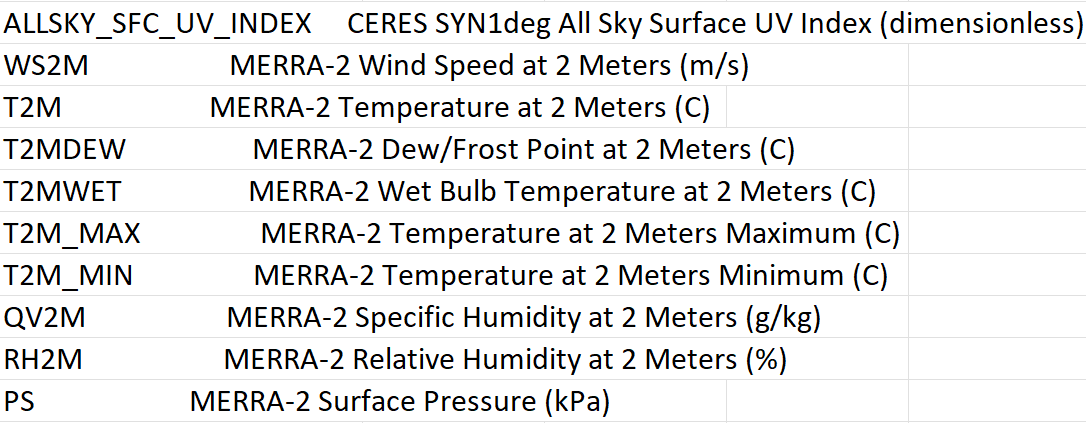

# DataFrame Energía-Clima

En esta sección hacemos una copia del dataframe de energía diaria por ciudad con la intención de hacer un nuevo dataframe con datos de la ciudad de *Hermosillo*

In [15]:
# Tomamos los datos de la ciudad de Hermosillo
energy_city = energy.loc[energy[' Zona de Carga'] == 'HERMOSILLO'].copy()
energy_city = energy_city.reset_index(drop=True)
energy_city.describe(include='number')


,Pronostico (MWh)
count,1559.000000
mean,13570.603352
std,6474.660361
min,5720.669000
25%,8806.650000
50%,11900.836000
75%,18449.191000
max,162239.425000


- ### **NOTA!**
El ```.describe(include='number')``` nos dice mucha información, principalmente, y para este caso, en el punto máximo. Si observamos bien, el punto máximo está en un orden de magnitud muy elevado, si también vemos los percentiles, vemos que el percentil 75, 75% de los datos tienen valores inferiores al indicado, y que los demás valores lleguen al valor máximo mostrado, es raro. Interpretar datos de esta forma y con sólo esa función puede llevar a un análisis no muy acertado, es por esto que decidimos graficar los datos, ovbservar e interpretar lo que está pasando.

<AxesSubplot: title={'center': 'Consumo de energía en Hermosillo'}, xlabel='Date'>

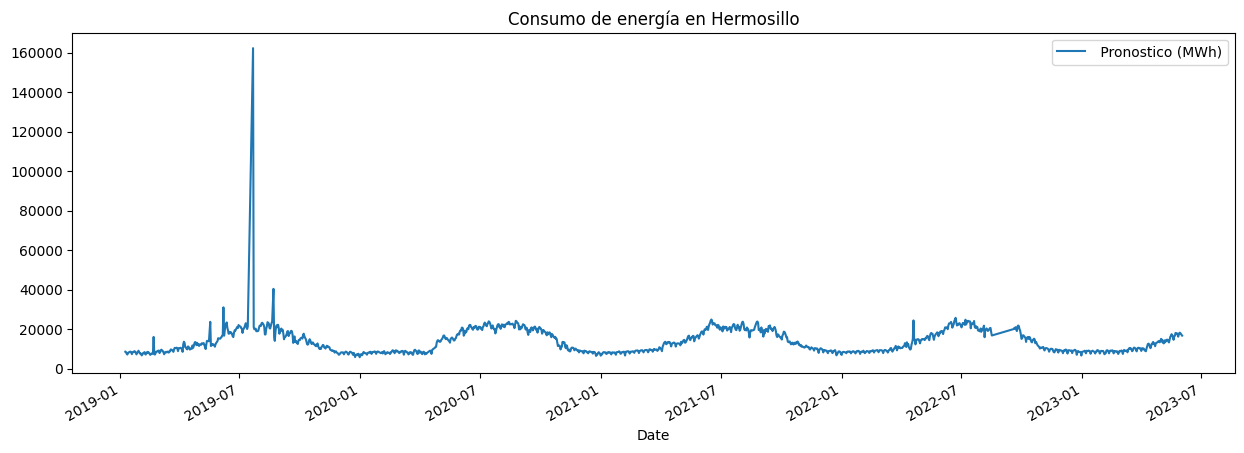

In [28]:
# Tomamos los datos de la ciudad de Hermosillo y graficamos
energy_city.plot(x='Date', y=' Pronostico (MWh)', figsize=(15, 5), title='Consumo de energía en Hermosillo')

Como se mencionó antes, aquí vemos cómo los datos presentan unos cuantos outliers. Si bien puede ser algún error de medición, o puede que sólo ese día haya habido un consumo así de elevado (dudoso dado que está en MWh). En fin, con la función ``` .max()``` buscamos los valores, porque vemos que hay como 4 outliers por ahí, y los borramos, esto ya que es la forma más practica para tratar con ellos, según nuestro conocimiento.

In [29]:
energy_city.max()

Date                 2023-06-02 00:00:00
 Zona de Carga                HERMOSILLO
 Pronostico (MWh)             162239.425
dtype: object

<AxesSubplot: title={'center': 'Consumo de energía en Hermosillo'}, xlabel='Date'>

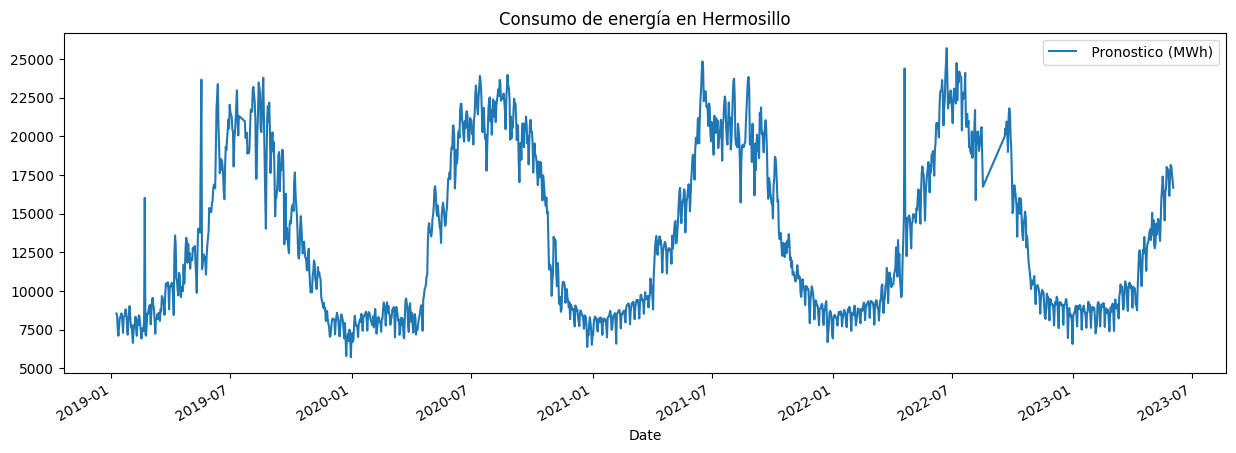

In [30]:
# Eliminar filas con valores que aparentemente son outliers
fechas_outliers = ['2019-06-07', '	2019-07-22', '2019-08-22','2020-08-24']
energy_city = energy_city.drop(energy_city[energy_city['Date'].isin(fechas_outliers)].index)

# Graficamos para ver el nuevo comportamiento
energy_city.plot(x='Date', y=' Pronostico (MWh)', figsize=(15, 5), title='Consumo de energía en Hermosillo')

Vemos que el comportamiento es más consistente. Es verdad que aparentemente hay otros outliers, o posibles outliers, sin embargo nuestro conocimiento no nos permite con certeza saber eso, así que es mejor dejarlos y continuar con nuestro estudio.

In [31]:
# Hacemos un merge del clima con la energía
clima_energia = energy_city.merge(clima_df, on='Date', how='inner')
clima_energia = clima_energia.reset_index(drop=True)
clima_energia.describe(include='number')

,Pronostico (MWh),ALLSKY_SFC_UV_INDEX,WS2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,QV2M,RH2M,PS
count,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000
mean,13442.890088,-134.065450,2.315090,23.578945,8.140708,15.859903,31.751178,16.887169,7.994704,44.179048,99.352555
std,5202.047917,342.947187,0.671852,6.678613,8.555881,6.820393,6.608578,6.751705,4.647860,16.689438,0.300598
min,5720.669000,-999.000000,0.770000,7.690000,-15.490000,0.710000,13.960000,0.440000,1.040000,6.810000,98.520000
25%,8806.588500,0.810000,1.800000,17.542500,2.260000,10.605000,26.457500,11.120000,4.640000,32.500000,99.130000
50%,11856.618000,1.620000,2.270000,23.520000,6.860000,14.655000,32.220000,16.050000,6.410000,43.120000,99.330000
75%,18380.096000,2.480000,2.747500,29.415000,14.685000,21.857500,36.897500,23.370000,10.830000,56.690000,99.570000
max,25699.446000,3.220000,4.990000,38.140000,24.480000,28.280000,46.300000,30.230000,19.470000,91.690000,100.300000


Ahora ya vemos que hay una mejor consistencia en los datos de Pronóstico de Energía. 
- La desviación estándar sigue siendo alta, esto es lógico dado que estamos tratando con un problema de series de tiempo y los datos no tienen porqué comportarse alrededor de su media, menos si hablamos del consumo de energía siendo que depende de muchas variables exógenas.
- Vemos que los comportamientos de Temperatura muestran un comportamiento esperado. 
  - Si nos fijamos en la *Temperatura Máxima* y en la *Temperatura Mínima*, vemos que sus promedios son valores normales y típicos en la ciudad de *Hermosillo*, tomando en cuenta los días que son normalmente *Frescos*, donde la temperatura anda por ahí de los 17°C y 20°C, y en los días donde no está fresco pero tampoco está muy caluroso, donde el clima está entre los 30°C y 32°C.

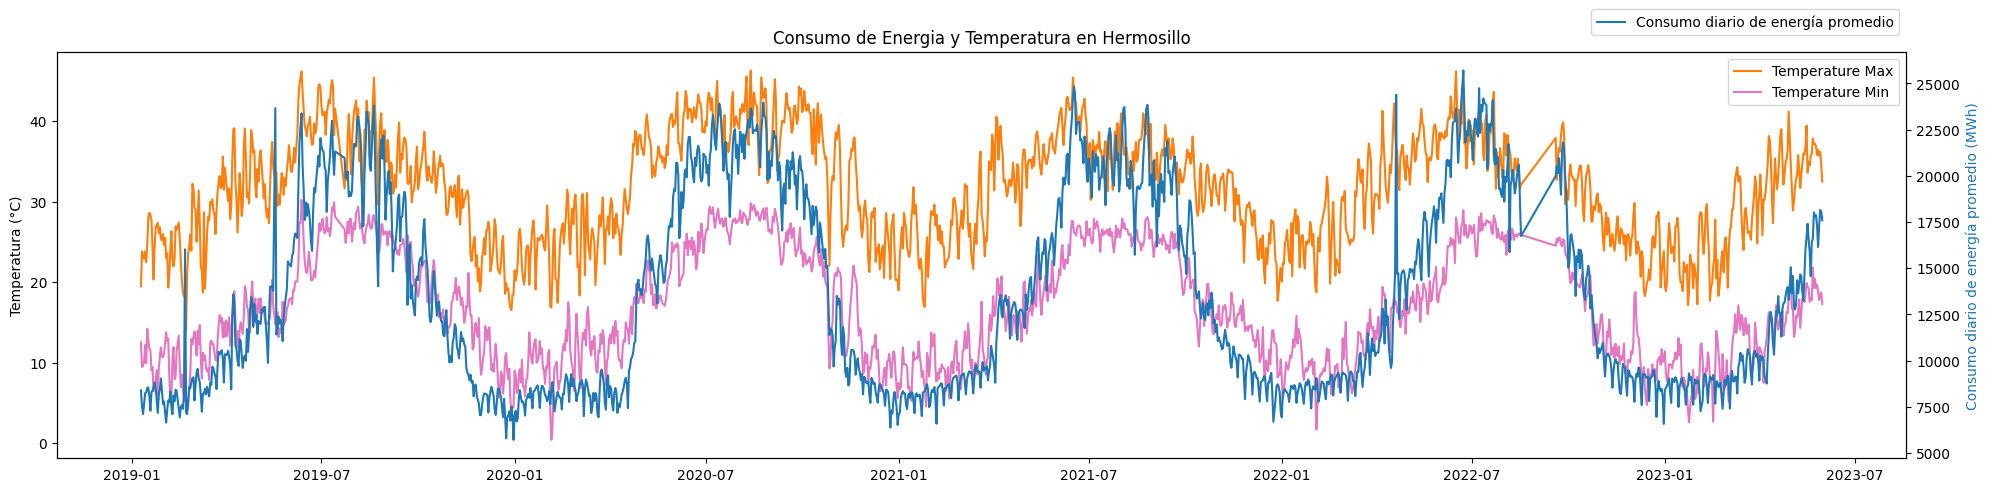

In [32]:
# Graficamos para ver el comportamiento de la temperatura contra el consumo de energía

# Escogemos las columnas que nos interesan, temperatura máxima, mínima
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(clima_energia['Date'][:-2], clima_energia['T2M_MAX'][:-2], color='tab:orange', label='Temperature Max')
ax1.plot(clima_energia['Date'][:-2], clima_energia['T2M_MIN'][:-2], color='tab:pink', label='Temperature Min')
ax1.set_ylabel('Temperatura (°C)')
ax1.legend()

ax2 = ax1.twinx()   # Compartir el eje x
# Escogemos la columnna de consumo de energía
ax2.plot(clima_energia['Date'][:-2], clima_energia[' Pronostico (MWh)'][:-2], color='tab:blue', label='Consumo diario de energía promedio')
ax2.set_ylabel('Consumo diario de energía promedio (MWh)', color='tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))

plt.title('Consumo de Energia y Temperatura en Hermosillo')
fig.tight_layout()  # Para que no se traslapen los ejes
plt.show()

Era un comportamiento esperado, vemos que el consumo tiende a subir cuando la temperatura en la ciudad aumenta. Efecto dado que en la ciudad de *Hermosillo* en temporadas de calor, el clima es muy abrasador, los hogares consumen mucha energía para abastecer sus casas con los aires acondicionados y más.  

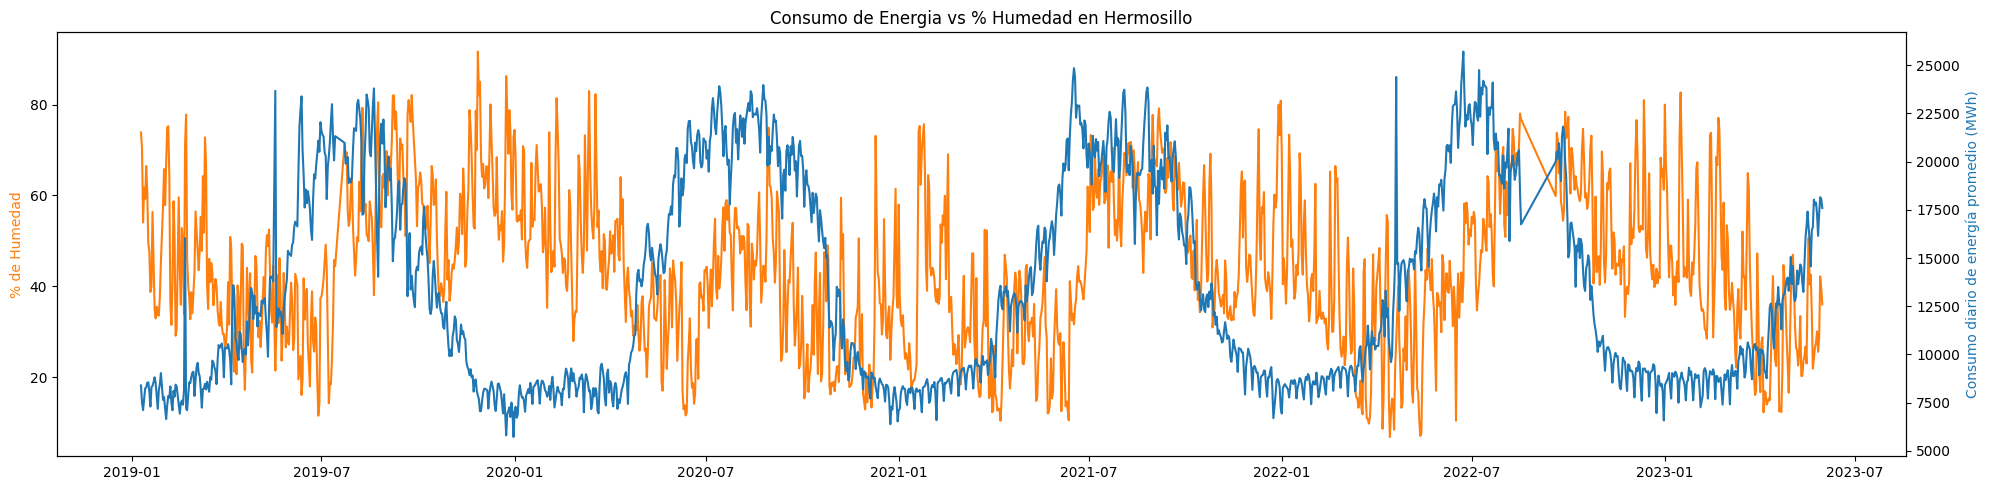

In [36]:
# Graficamos para ver el comportamiento de la humedad contra el consumo de energía
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(clima_energia['Date'][:-2], clima_energia['RH2M'][:-2], color='tab:orange', label='Humedad')
ax1.set_ylabel(f'% de Humedad', color='tab:orange')

ax2 = ax1.twinx()  # Compartir el eje x
# Escogemos la columnna de consumo de energía
ax2.plot(clima_energia['Date'][:-2], clima_energia[' Pronostico (MWh)'][:-2], color='tab:blue', label='Consumo diario de energía promedio')
ax2.set_ylabel('Consumo diario de energía promedio (MWh)', color='tab:blue')

plt.title(f'Consumo de Energia vs % Humedad en Hermosillo')
fig.tight_layout()
plt.show()

Otro comportamiento esperado. Recordemos que la *Humedad Relativa* es el porcentaje de agua (vapor) que hay en el aire. El clima en la ciudad de *Hermosillo* es seco, en comparación a otras ciudades. Cuando es verano, el clima no es muy húmedo dado que la temperatura es muy elevada. Sin embargo, cuando la temperatura tiende a disminuir, la humedad aumenta, dando climas más frescos en nuestra ciudad, y como resultado, los hogares no requieran prender los aires acondicionados, etc.
* Esta relación no es lineal, es una relación más compleja, solo que se da en nuestra ciudad dada las condiciones de la región, un lugar seco y alejado del mar, entre muchas otras cosas más.
* Se dice que era lo esperado porque es la experiencia de vivir en la ciudad, nomás que ahora demostrada con datos.

In [37]:
# Como queremos ver la relación del consumo de energía con el clima, hacemos lo siguiente
corr = clima_energia.corr(numeric_only=True)
corr

,Pronostico (MWh),ALLSKY_SFC_UV_INDEX,WS2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,QV2M,RH2M,PS
Pronostico (MWh),1.000000,0.195800,0.113658,0.921075,0.675844,0.874900,0.833953,0.921710,0.717039,0.041573,-0.684490
ALLSKY_SFC_UV_INDEX,0.195800,1.000000,-0.071812,0.221511,0.243203,0.260984,0.185888,0.253227,0.246760,0.105094,-0.169039
WS2M,0.113658,-0.071812,1.000000,0.102677,-0.179447,-0.062298,0.157786,0.017832,-0.163490,-0.293021,-0.172308
T2M,0.921075,0.221511,0.102677,1.000000,0.597195,0.864222,0.956048,0.962800,0.628373,-0.115653,-0.736494
T2MDEW,0.675844,0.243203,-0.179447,0.597195,1.000000,0.919651,0.387625,0.743849,0.969614,0.706793,-0.429732
T2MWET,0.874900,0.260984,-0.062298,0.864222,0.919651,1.000000,0.711249,0.937996,0.915859,0.386710,-0.630164
T2M_MAX,0.833953,0.185888,0.157786,0.956048,0.387625,0.711249,1.000000,0.853148,0.422021,-0.343157,-0.700427
T2M_MIN,0.921710,0.253227,0.017832,0.962800,0.743849,0.937996,0.853148,1.000000,0.773288,0.094210,-0.691712
QV2M,0.717039,0.246760,-0.163490,0.628373,0.969614,0.915859,0.422021,0.773288,1.000000,0.657080,-0.434564
RH2M,0.041573,0.105094,-0.293021,-0.115653,0.706793,0.386710,-0.343157,0.094210,0.657080,1.000000,0.071192


Si bien los números pueden decir mucho, una imagen puede decir más. Por esta razón hacemos lo siguiente.

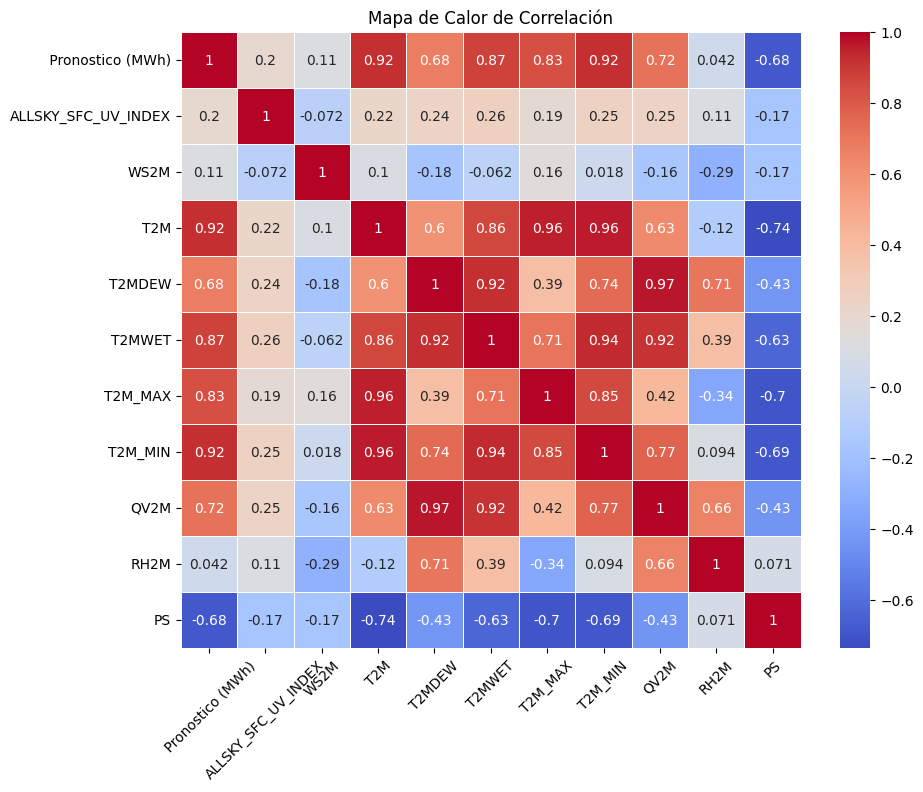

In [ ]:
import seaborn as sns

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)

# Personalizar el gráfico
plt.title("Mapa de Calor de Correlación")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

* Vemos que hay variables que tienen mucha relación. Las variables de temperatura (del bulbo húmedo, punto de rocío, máxima, mínima, etc) tienen mejor relación que otras.
* Recordemos que un valor de 0 no indica que no exista relación, simplemente su relación no es lineal. Pero puede tener relación no lineal, o compleja.

# Clusters del Clima

* Los clusters sirven para la agrupación de datos, en este caso datos climáticos. Estos grupos se forman basados en características propias de los datos y lo hacemos con la intención de encontrar su impacto, o patrones, que nos puedan servir en la predicción de la demanda de energía.
* Este es un trabajo basado en un kaggle, decidimos seguir las variables que ellos utilizaron, además de ser variables que creemos están acordes a la situación.

In [40]:
# scaler sirve para escalar los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))

# fit_transform sirve para ajustar los datos y transformarlos en un rango de 0 a 1
clima_escalado = scaler.fit_transform(clima_energia[['T2M_MAX', 'RH2M','WS2M']])
clima_escalado 

array([[0.1716141 , 0.79017436, 0.13033175],
       [0.30519481, 0.74893968, 0.18720379],
       [0.28076685, 0.55666824, 0.26777251],
       ...,
       [0.57328386, 0.34389727, 0.55687204],
       [0.54483612, 0.3917295 , 0.51421801],
       [0.62430427, 0.38371819, 0.3056872 ]])

K-means es un algoritmo de aprendizaje automático no supervisado y nos ayuda a agrupar los datos, haciendo que sean similares entre sí y diferente entre los demás.\
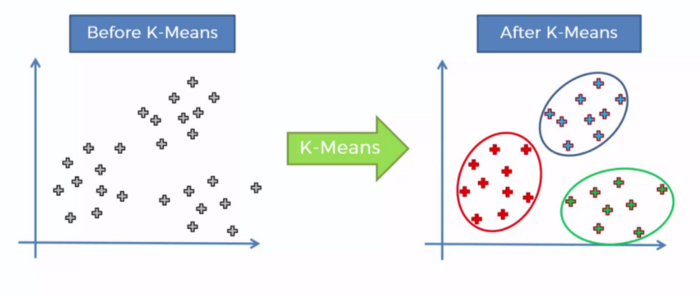

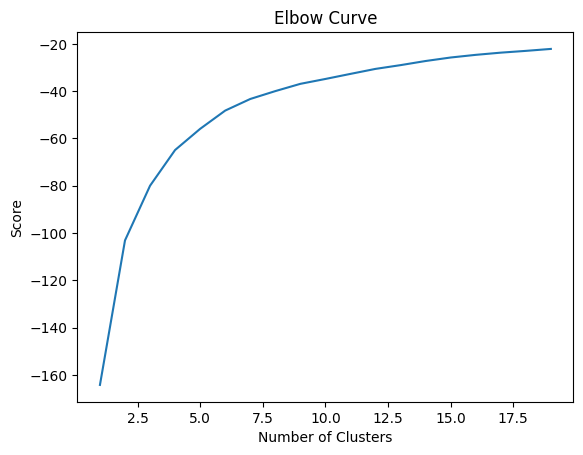

In [110]:
# k optima para kmeans
Nc = range(1, 20)   # Número de clusters
kmeans = [KMeans(n_clusters=i, n_init=10) for i in Nc]

# score es la suma de las distancias al cuadrado de cada punto al centroide más cercano
score = [kmeans[i].fit(clima_escalado).score(clima_escalado) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')    
plt.show()

El Elbow Curve ayuda a determinar el número óptimo de clústeres (grupos) en un conjunto de datos.

In [43]:
# A los datos del clima, los ajustamos a 5 clusters y los fitteamos con kmeans
kmeans = KMeans(n_clusters=5, n_init=10,max_iter=600, algorithm = 'lloyd')
kmeans.fit(clima_escalado)
clima_energia['clima_cluster'] = kmeans.labels_
clima_energia.head(3)

,Date,Zona de Carga,Pronostico (MWh),ALLSKY_SFC_UV_INDEX,WS2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,QV2M,RH2M,PS,clima_cluster
0,2019-01-10,HERMOSILLO,8393.639,0.29,1.32,15.51,10.71,13.11,19.51,12.54,8.06,73.88,99.83,4
1,2019-01-11,HERMOSILLO,7505.129,0.91,1.56,15.61,9.57,12.58,23.83,9.48,7.57,70.38,99.75,4
2,2019-01-12,HERMOSILLO,7114.879,0.91,1.90,15.57,5.82,10.69,23.04,9.62,5.80,54.06,99.74,4


In [64]:
clima_energia.tail(3)

,Date,Zona de Carga,Pronostico (MWh),ALLSKY_SFC_UV_INDEX,WS2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,QV2M,RH2M,PS,clima_cluster
1551,2023-05-31,HERMOSILLO,17591.781,-999.0,3.12,25.01,7.00,16.01,32.50,17.32,6.53,36.00,99.00,3
1552,2023-06-01,HERMOSILLO,17086.090,-999.0,2.94,24.01,8.31,16.16,31.58,17.21,6.96,40.06,99.13,3
1553,2023-06-02,HERMOSILLO,16674.799,-999.0,2.06,25.52,8.90,17.21,34.15,17.62,7.26,39.38,99.14,0


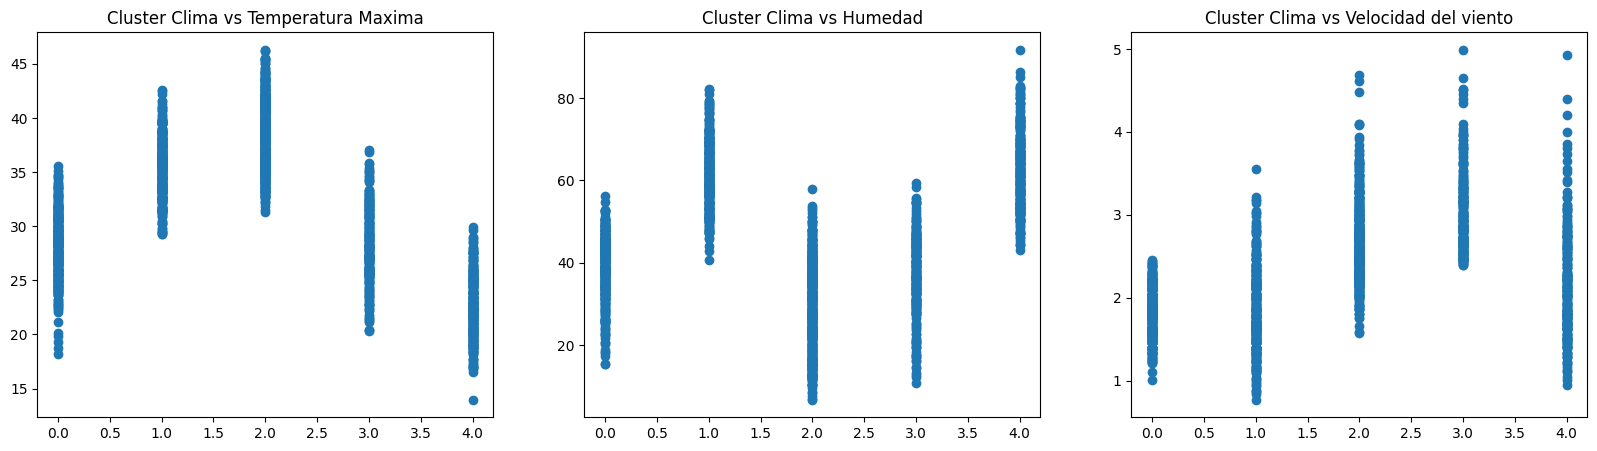

In [44]:
# Graficamos los clusters y vemos cómo se comportan con la temperatura máxima, humedad y velocidad del viento
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(clima_energia.clima_cluster[:-2], clima_energia.T2M_MAX[:-2])
plt.title('Cluster Clima vs Temperatura Maxima')

plt.subplot(1, 3, 2)
plt.scatter(clima_energia.clima_cluster[:-2], clima_energia.RH2M[:-2])
plt.title('Cluster Clima vs Humedad')

plt.subplot(1, 3, 3)
plt.scatter(clima_energia.clima_cluster[:-2], clima_energia.WS2M[:-2])
plt.title('Cluster Clima vs Velocidad del viento')

plt.show()

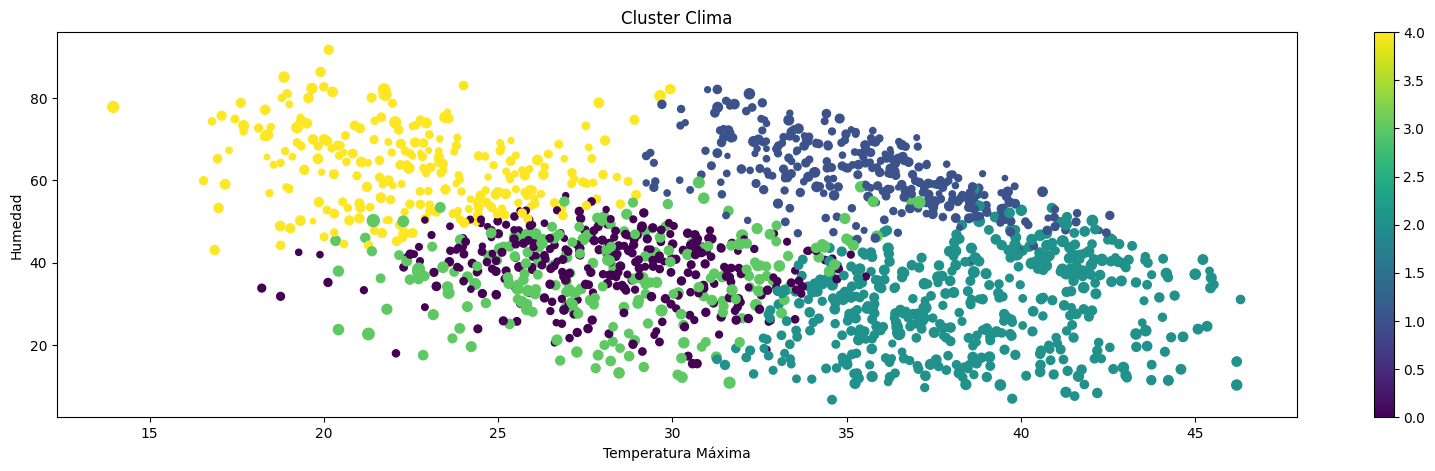

In [49]:
# Graficamos en un scatter plot la temperatura máxima contra la humedad y el tamaño de los puntos sea la velocidad del viento
# Los colores indican el cluster al que pertenecen los datos del clima (0, 1, 2, 3, 4)
fig, ax1 = plt.subplots(figsize=(20, 5))
scatter = ax1.scatter(clima_energia.T2M_MAX[:-2], 
                      clima_energia.RH2M[:-2],
                      s=clima_energia.WS2M[:-2]*15,
                      c=clima_energia.clima_cluster[:-2])
ax1.set_xlabel('Temperatura Máxima')
ax1.set_ylabel('Humedad')

plt.colorbar(scatter)        # Agregar la barra de colores
plt.title('Cluster Clima')
plt.show()


Podemos notar lo siguiente:
- La temperatura, mientras más va aumentando, la humedad (relativa)[^1] disminuye.
- Aunque no se alcanza a ver, el tamaño de los puntos indica la influencia de la velocidad del viento entre estas variables de clima, y al parecer no tiene gran relevancia.

[^1]: La humedad relativa indica el % de agua (humedad) que hay en el aire

# Indicador de dias festivos


In [61]:
# Vamos a la dirección donde tenemos los datos de los días festivos
os.chdir(r'C:\Users\Panda\Documents\GitHub\energyPrediction')

# Leemos los datos
holiday = pd.read_csv('holidays.csv')

# Convertir la columna 'Fecha' a datetime
holiday['Fecha'] = pd.to_datetime(holiday['Fecha'], format='%d/%m/%Y')
holiday.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Fecha        114 non-null    datetime64[ns]
 1   Día festivo  114 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.9+ KB


In [80]:
# Hacemos un merge de los datos de clima y energía con los datos de los días festivos
clima_energia_2 = clima_energia.merge(holiday, left_on='Date', right_on='Fecha', how='left').copy()

# Si la columna 'Fecha' es nula, entonces no es un día festivo, por lo que le asignamos un 0
clima_energia_2['Holiday_ind'] = np.where(clima_energia_2['Fecha'].isnull(), 0, 1)
# Eliminamos la columna 'Fecha' ya que no es necesaria
clima_energia_2 = clima_energia_2.drop(columns=['Fecha'])

In [81]:
# Vemos los datos con los días festivos nomás para ver si se hizo buen merge
clima_energia_2.loc[clima_energia_2['Holiday_ind'] == 1].head(3)

# Setteamos la columna 'Date' como índice
clima_energia_2.set_index(['Date'], inplace=True)
clima_energia_2.head(3)

,Zona de Carga,Pronostico (MWh),ALLSKY_SFC_UV_INDEX,WS2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,QV2M,RH2M,PS,clima_cluster,Día festivo,Holiday_ind
Date,,,,,,,,,,,,,,,
2019-01-10,HERMOSILLO,8393.639,0.29,1.32,15.51,10.71,13.11,19.51,12.54,8.06,73.88,99.83,4,NaN,0
2019-01-11,HERMOSILLO,7505.129,0.91,1.56,15.61,9.57,12.58,23.83,9.48,7.57,70.38,99.75,4,NaN,0
2019-01-12,HERMOSILLO,7114.879,0.91,1.90,15.57,5.82,10.69,23.04,9.62,5.80,54.06,99.74,4,NaN,0


## Modelo de Series Temporales

In [82]:
# Escogemos las columnas que nos interesan para el modelo
model_data = clima_energia_2[['Holiday_ind', ' Pronostico (MWh)','clima_cluster']]

# Separamos los datos de entrenamiento y prueba
train = model_data.iloc[0:(len(model_data)-30)]             # El entrenamiento son todos los datos menos los últimos 30 días
test = model_data.iloc[len(train):(len(model_data))]      # La prueba son los últimos 30 días

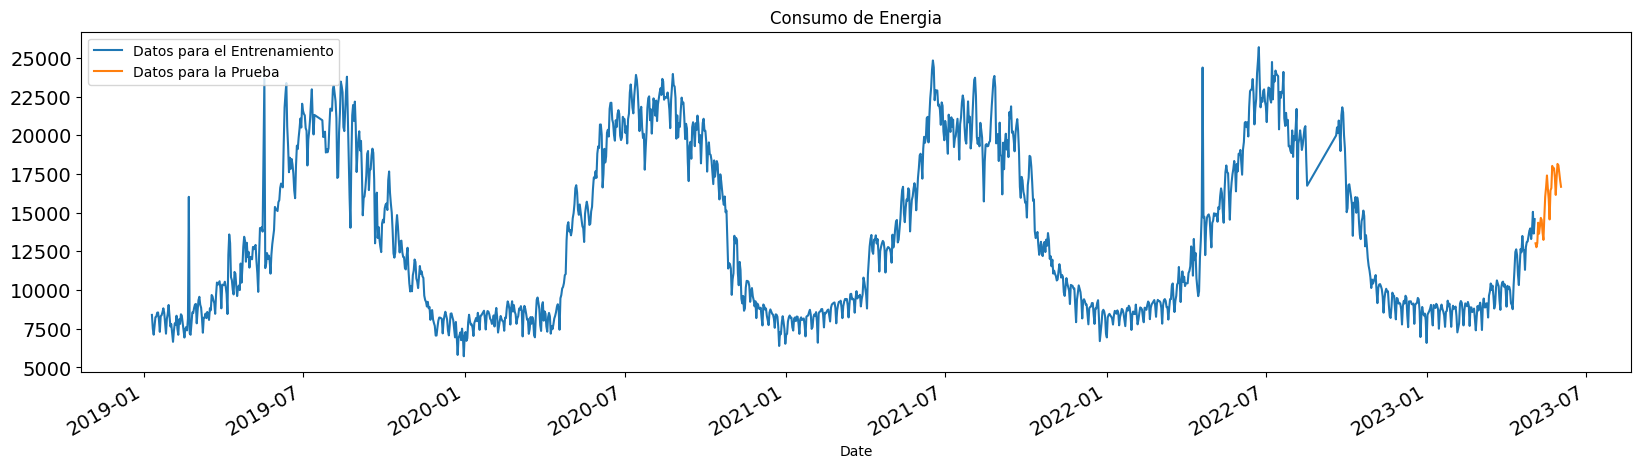

In [149]:
train[' Pronostico (MWh)'].plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
test[' Pronostico (MWh)'].plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
plt.legend(['Datos para el Entrenamiento', 'Datos para la Prueba'], loc='upper left')

Este lógicamente no es el entrenamiento. Sólo es para ver cómo fueron separados los datos, y qué días van a abarcar los días de testeo para la predicción

- ## Seasonal Decomposition

La descomposición estacional (seasonal decomposition) es un procedimiento estadístico que se utiliza para descomponer una serie de tiempo en sus componentes fundamentales: tendencia, estacionalidad y residuos. Esto es especialmente relevante en un modelo de este tipo cuando se incluyen variables predictoras que pueden estar relacionadas con la estacionalidad y la tendencia de la serie de tiempo. En otras palabras, ayuda a obtener estimaciones más precisas y mejores predicciones.

* Estacionalidad (Seasonality): Identifica patrones que se repiten en ciertos intervalos de tiempo, como estaciones del año, meses, semanas o días de la semana.
* Tendencia (Trend): La tendencia representa la dirección general de los datos a medida que se mueven en una dirección específica a lo largo del tiempo. 
* Residuo (Residual): Los residuos son las partes de los datos que no pueden explicarse por la estacionalidad ni por la tendencia. Representan las variaciones impredecibles o aleatorias en los datos.

In [114]:
import statsmodels.api as sm

<AxesSubplot: title={'center': 'Seasonality'}, xlabel='Date'>

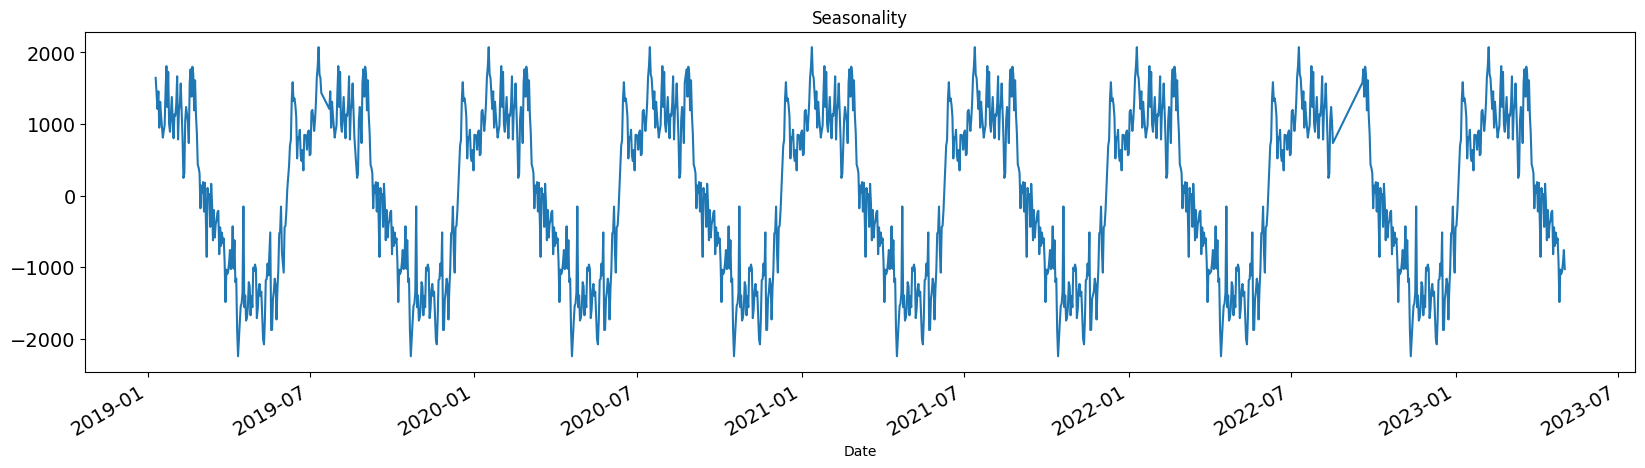

In [115]:
# period de 180 (6 meses) porque si usaramos la frecuencia semana o diaria, no se vería bien
s = sm.tsa.seasonal_decompose(train[' Pronostico (MWh)'], period=180) 
s.seasonal.plot(figsize=(20,5), title= 'Seasonality', fontsize=14)

La presencia de valores negativos, en el eje *y*, indica que la serie de tiempo está por debajo de la media en esos puntos específicos en relación con el patrón estacional ([OpenAI](#referencias)).

Text(0, 0.5, 'Consumo de Energia')

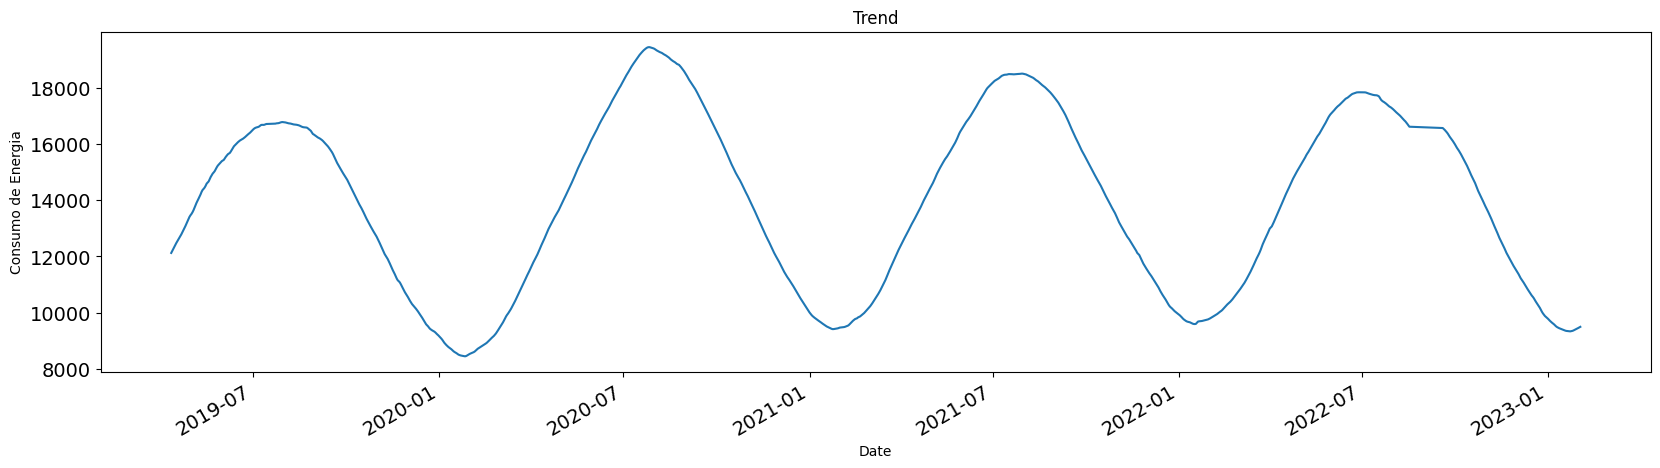

In [116]:
s.trend.plot(figsize=(20,5), title= 'Trend', fontsize=14)
plt.ylabel('Consumo de Energia')

<AxesSubplot: title={'center': 'Residual'}, xlabel='Date'>

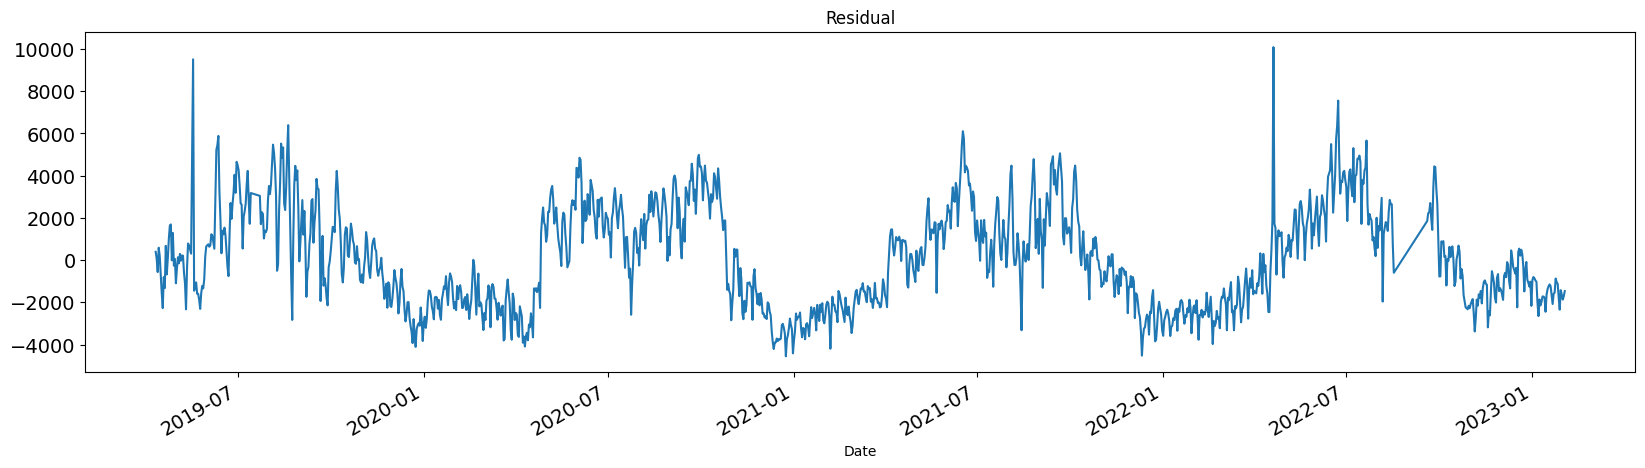

In [117]:
s.resid.plot(figsize=(20,5), title= 'Residual', fontsize=14)

- ## SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables)
Este es uno de los modelos estadísticos más utilizados cuando se trata de problemas de series de tiempo. Al utilizar [SARIMAX](#referencias), se pueden estimar los parámetros del modelo a partir de datos históricos y luego utilizar el modelo ajustado para realizar pronósticos futuros. En términos sencillos, SARIMAX permite modelar y predecir una serie de tiempo teniendo en cuenta tanto los patrones estacionales y de tendencia inherentes a la serie como las influencias externas o factores exógenos que pueden afectarla. 

In [118]:
# La variable endog es la variable dependiente y la cual queremos predecir
endog = train[' Pronostico (MWh)']

# La variable exog es la variable independiente y la cual queremos usar para predecir
exog = train[['Holiday_ind', 'clima_cluster']]

# El modelo SARIMAX es un modelo de series de tiempo que toma en cuenta la estacionalidad
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)

# fit() sirve para ajustar el modelo
model_fit = mod.fit()

c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


- ## Model Fit
Vemos cómo queda el modelo conforme a nuestro datos, esto mediante una gráfica y comparando.

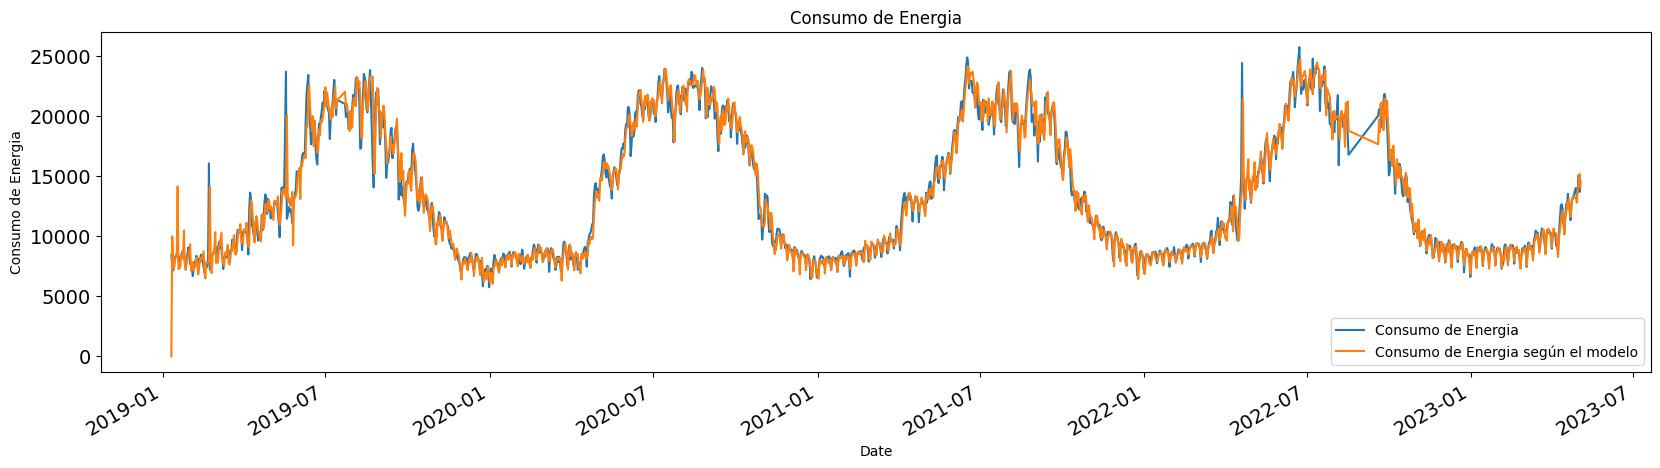

In [134]:
# Escogemos los datos de entrenamiento
train[' Pronostico (MWh)'].plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)

# Escogemos los datos predichos por el modelo
model_fit.fittedvalues.plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)

# Graficamos
plt.legend(['Consumo de Energia', 'Consumo de Energia según el modelo'], loc = 'lower right')
plt.ylabel('Consumo de Energia')
plt.show()

Observando esta gráfica podemos decir que nuestro modelo se ajusta de buena forma con los datos históricos.

# Predicción

Predicción a futuro utilizando el modelo ajustado ([model fit](#model-fit)).

In [147]:
# Predict sirve para predecir los datos de prueba
predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=test[['Holiday_ind', 'clima_cluster']]) # type: ignore
test['Prediccion'] = predict.values
test

# Recordemos que son 30 días de prueba

c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Panda\AppData\Local\Temp\ipykernel_14964\2837229628.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediccion'] = predict.values


,Holiday_ind,Pronostico (MWh),clima_cluster,Prediccion,residual
Date,,,,,
2023-05-04,0,13021.986,3,14426.695741,1404.709741
2023-05-05,1,12766.219,3,13854.886796,1088.667796
2023-05-06,0,13030.178,2,13179.268744,149.090744
2023-05-07,0,14350.632,2,14328.285268,22.346732
2023-05-08,0,13643.851,2,14937.832210,1293.981210
2023-05-09,0,14123.317,2,14821.153297,697.836297
2023-05-10,1,14665.098,3,14897.563117,232.465117
2023-05-11,0,14532.700,2,14944.859418,412.159418
2023-05-12,0,13718.101,2,14560.052521,841.951521


Analizando los datos podemos ver que hay días que la predicción es buena, sin embargo, hay unos días donde la diferencia aparenta ser mucha. Para esto haremos uso de dos conceptos.
* MAE (Mean Absolute Error):
El MAE es una medida de error absoluto promedio. Calcula la diferencia absoluta promedio entre las predicciones del modelo y los valores reales.
   * $ {1\over n} \sum_{i=1}^{n}|y_i- \hat y_i| $
* MAPE (Mean Absolute Percentage Error):
El MAPE es una medida de error porcentual promedio. Calcula el porcentaje promedio de diferencia absoluta entre las predicciones del modelo y los valores reales en relación con los valores reales.
   * $ {1\over n} \sum_{i=1}^{n}|{y_i- \hat y_i\over y_i}| * 100 $

$ y $
: Es nuestro valor actual \
$ \hat y $
: Es nuestro valor predecido, o pronosticado

In [151]:
test['residual'] = abs(test[' Pronostico (MWh)'] - test['Prediccion'])
MAE = test['residual'].sum()/len(test)
MAPE = (test['residual']/test[' Pronostico (MWh)']).sum()*100/len(test)
print('MAE: ', MAE)
print('MAPE: ', MAPE)

MAE:  978.4047263812063
MAPE:  6.047542680231185


C:\Users\Panda\AppData\Local\Temp\ipykernel_14964\312076015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residual'] = abs(test[' Pronostico (MWh)'] - test['Prediccion'])


Con estos valores de *MAE* y *MAPE* podemos ver que, aparentemente, el *MAPE* no es muy grande, eso en mi opinión; siendo que trabajamos con valores de magnitud muy grande, podríamos decir que es un valor aceptable dentro de lo que cabe. Algo que también podemos notar en el *MAPE* es que es un porcentaje aceptable, un porcentaje de error muy acertado para el modelo que creamos con las variables que utilizamos.

Estos dos conceptos nos ayudan a evaluar nuestro modelo de regresión, lo cual indica tener una buena estimación.

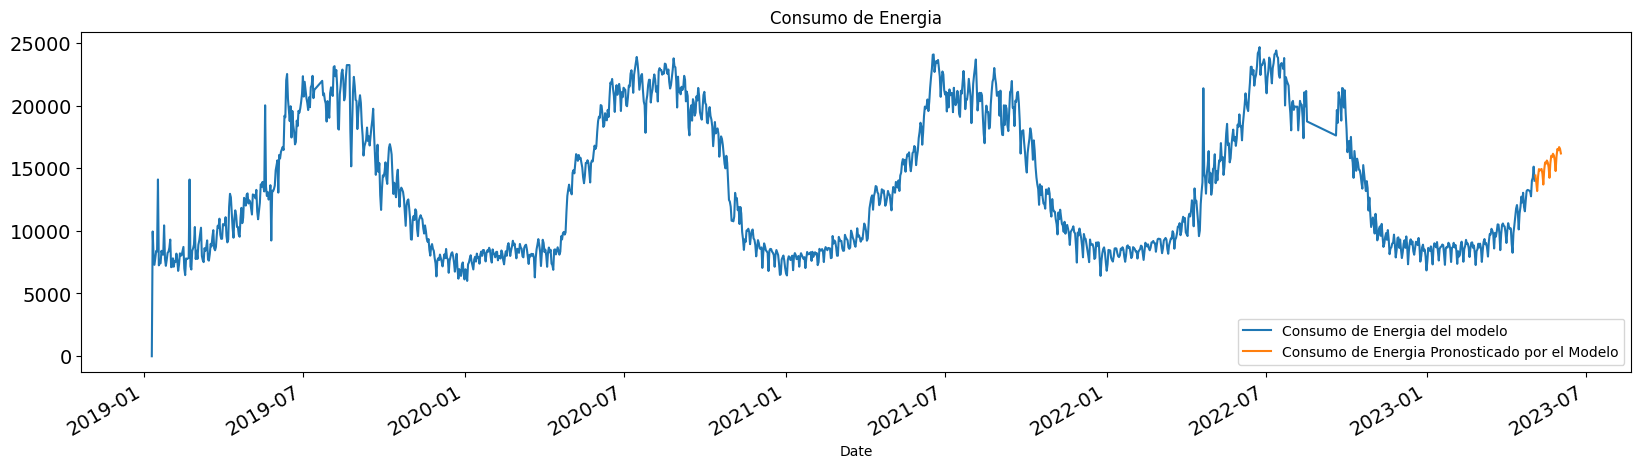

In [148]:
# Graficamos los datos de prueba contra los datos predichos
model_fit.fittedvalues.plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
test['Prediccion'].plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
plt.legend(['Consumo de Energia del modelo', 'Consumo de Energia Pronosticado por el Modelo'])

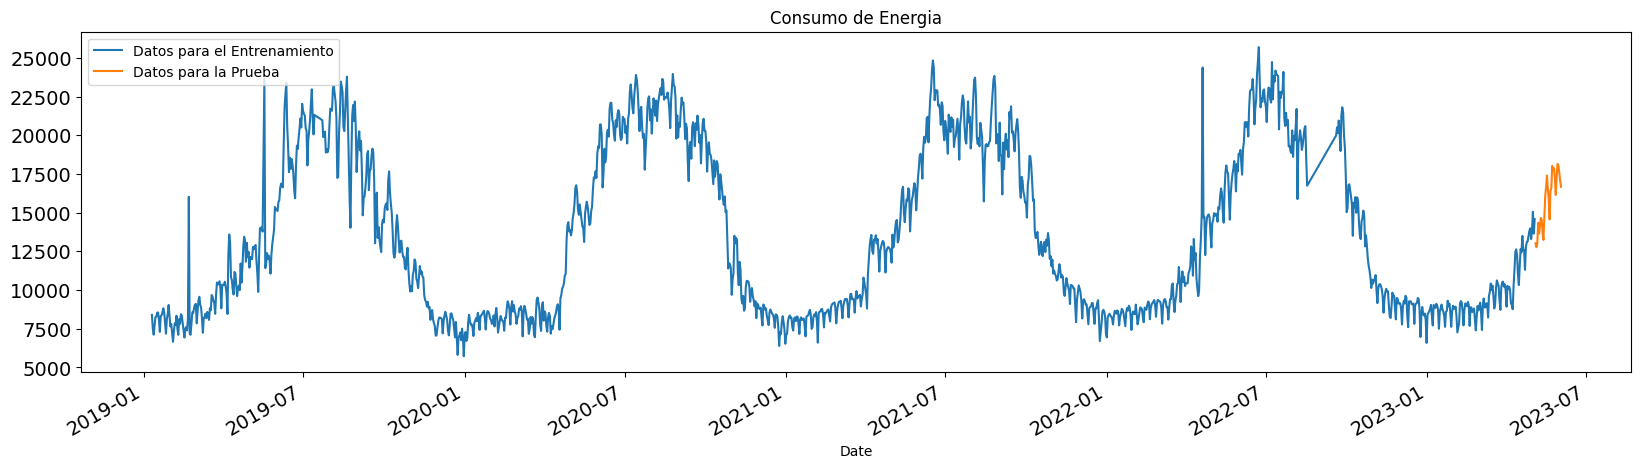

# Conclusión
La primera gráfica es una representación de cómo es el comportamiento del modelo que creamos, la cola que se ve (color naranja), son los datos que el modelo no vio y con los que hicimos el testeo para ver qué tan diferentes eran los valores de predicción en comparación a los reales, y vemos que en esta primera gráfica, hay un comportamiento bastante aceptable. Los datos originales son los que se muestran en la segunda gráfica, vemos que el comportamiento de la cola (nuevamente, el color naranja) es similar al comportamiento que predice nuestro modelo. Si bien, la segunda gráfica, su cola va de forma más elevada; pues hay que recordar que nuestro modelo **empieza** desde 0, y la gráfica se crea ajustándose a esto. Es por eso que pareciera que sí hay mucha diferencia, pero solo basta con ver el DataFrame de ``` test``` y comparar sus datos para ver que no es así.

# Referencias

* rheajgurung. (2018, December 11). Energy Consumption Forecast. Kaggle.com; Kaggle. https://www.kaggle.com/code/rheajgurung/energy-consumption-forecast

* CIMAT. (2023). Women in Data Science (WiDS) 2023 [YouTube Video]. In YouTube. https://www.youtube.com/watch?v=QcP3tU3uMYo&t=3594s

* Stackhouse, P. (2022). NASA POWER | Prediction Of Worldwide Energy Resources. Nasa.gov. https://power.larc.nasa.gov/

* OpenAI. (2021). ChatGPT (Version 3.5) [Software]. Recuperado de https://openai.com 
‌
* Nguyen, B. (2021, February 6). End-to-End Time Series Analysis and Forecasting: a Trio of SARIMAX, LSTM and Prophet (Part 1). Medium; Towards Data Science. https://towardsdatascience.com/end-to-end-time-series-analysis-and-forecasting-a-trio-of-sarimax-lstm-and-prophet-part-1-306367e57db8#:~:text=What%20is%20SARIMAX%3F,%2Daverage%20term%20(MA).

‌